In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
models = [
    "UNETR",
    "nnFormer",
    "TC-CoNet",
    "D-LKA Net",
    "neU-Net",
    "MOSformer",
    "MS-TCNet",
    "LHU-Net",
]
flops = [
    "77.84 G",
    "47.73 G",
    "145.16 G",
    "43.71 G",
    "129.83 G",
    "100.06 G",
    "172.89 G",
    "23.2 G",
]
params = [92.6, 37.16, 86.79, 66.8, 161.28, 77.09, 59.49, 5.43]
dice = [88.61, 91.78, 91.58, 91.59, 92.11, 92.19, 91.43, 92.46]

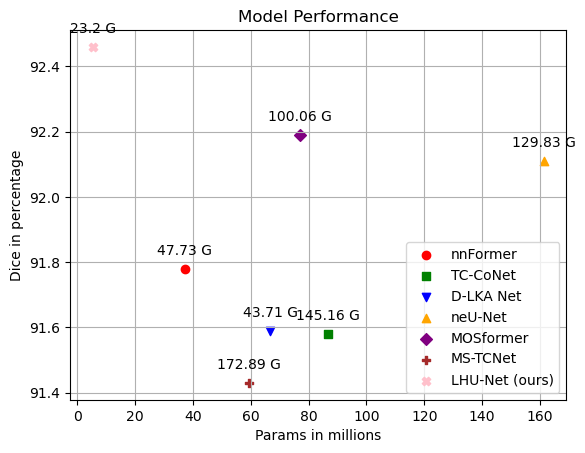

In [12]:
import matplotlib.pyplot as plt

# models = ['UNETR', 'nnFormer', 'TC-CoNet', 'D-LKA Net', 'neU-Net', 'MOSformer', 'MS-TCNet', 'LHU-Net']
# flops = ['77.84 G', '47.73 G', '145.16 G', '43.71 G', '129.83 G', '100.06 G', '172.89 G', '23.2 G']
# params = [92.6, 37.16, 86.79, 66.8, 161.28, 77.09, 59.49, 5.43]
# dice = [88.61, 91.78, 91.58, 91.59, 92.11, 92.19, 91.43, 92.46]

models = [
    "nnFormer",
    "TC-CoNet",
    "D-LKA Net",
    "neU-Net",
    "MOSformer",
    "MS-TCNet",
    "LHU-Net (ours)",
]
flops = ["47.73 G", "145.16 G", "43.71 G", "129.83 G", "100.06 G", "172.89 G", "23.2 G"]
params = [37.16, 86.79, 66.8, 161.28, 77.09, 59.49, 5.43]
dice = [91.78, 91.58, 91.59, 92.11, 92.19, 91.43, 92.46]

# Define colors and shapes for each point
colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray"]
shapes = ["o", "s", "v", "^", "D", "P", "X", "h"]

# Plot scatter plot with different colors and shapes
for i in range(len(models)):
    plt.scatter(params[i], dice[i], color=colors[i], marker=shapes[i], label=models[i])
    plt.annotate(
        flops[i],
        (params[i], dice[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

# Add legend
plt.legend()

# Add labels and title
plt.xlabel("Params in millions")
plt.ylabel("Dice in percentage")
plt.title("Model Performance")

# Add grid
plt.grid(True)

# Show the plot
plt.show()

# models = ['UNETR', 'nnFormer', 'TC-CoNet', 'D-LKA Net', 'neU-Net', 'MOSformer', 'MS-TCNet', 'LHU-Net']
# flops = ['77.84 G', '47.73 G', '145.16 G', '43.71 G', '129.83 G', '100.06 G', '172.89 G', '23.2 G']
# params = [92.6, 37.16, 86.79, 66.8, 161.28, 77.09, 59.49, 5.43]
# dice = [88.61, 91.78, 91.58, 91.59, 92.11, 92.19, 91.43, 92.46]

# # Define colors and shapes for each point
# colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray']
# shapes = ['o', 's', 'v', '^', 'D', 'P', 'X', 'h']

# # Plot scatter plot with different colors and shapes
# for i in range(len(models)):
#     plt.scatter(params[i], dice[i], color=colors[i], marker=shapes[i], label=models[i])

# # Add legend
# plt.legend()

# # Add labels and title
# plt.xlabel('Params in millions')
# plt.ylabel('Dice in percentage')
# plt.title('Model Performance')

# # Add grid
# plt.grid(True)

# # Show the plot
# plt.show()

# # FILEPATH: /home/say26747/Desktop/git/brats2018/test.ipynb
# models = ['UNETR', 'nnFormer', 'TC-CoNet', 'D-LKA Net', 'neU-Net', 'MOSformer', 'MS-TCNet', 'LHU-Net']
# flops = ['77.84 G', '47.73 G', '145.16 G', '43.71 G', '129.83 G', '100.06 G', '172.89 G', '23.2 G']
# params = [92.6, 37.16, 86.79, 66.8, 161.28, 77.09, 59.49, 5.43]
# dice = [88.61, 91.78, 91.58, 91.59, 92.11, 92.19, 91.43, 92.46]

# # Plot scatter plot
# plt.scatter(params, dice)

# # Add labels to each point
# for i in range(len(models)):
#     plt.annotate(flops[i], (params[i], dice[i]), textcoords="offset points", xytext=(0,10), ha='center')

# # Add legend
# plt.legend(models)

# # Add labels and title
# plt.xlabel('Params')
# plt.ylabel('Dice')
# plt.title('Model Performance')

# # Show the plot
# plt.show()

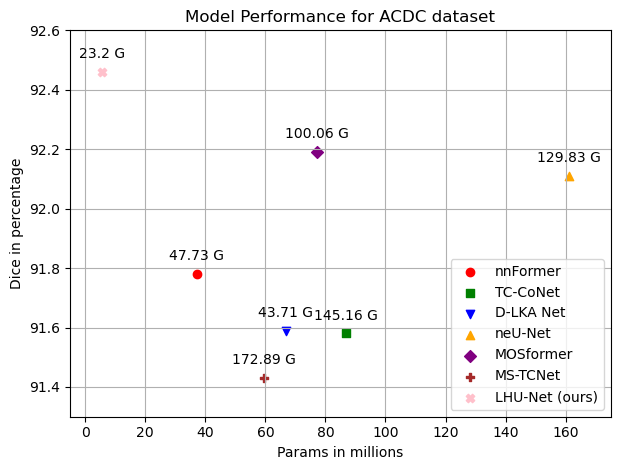

In [13]:
# Plot scatter plot with different colors and shapes
for i in range(len(models)):
    plt.scatter(params[i], dice[i], color=colors[i], marker=shapes[i], label=models[i])
    plt.annotate(
        flops[i],
        (params[i], dice[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

# Add legend
plt.legend()

# Add labels and title
plt.xlabel("Params in millions")
plt.ylabel("Dice in percentage")
plt.title("Model Performance for ACDC dataset")

# Add grid
plt.grid(True)

# Add more space to the plot from all sides
plt.tight_layout()
plt.xlim(-5, 175)
plt.ylim(91.3, 92.6)

# Show the plot
plt.show()

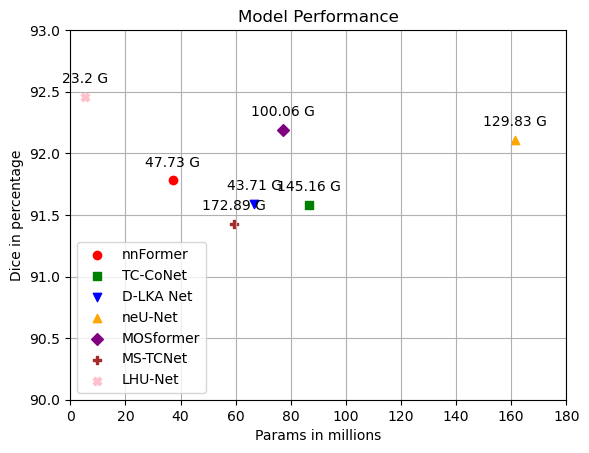

In [10]:
import matplotlib.pyplot as plt

# models = ['UNETR', 'nnFormer', 'TC-CoNet', 'D-LKA Net', 'neU-Net', 'MOSformer', 'MS-TCNet', 'LHU-Net']
# flops = ['77.84 G', '47.73 G', '145.16 G', '43.71 G', '129.83 G', '100.06 G', '172.89 G', '23.2 G']
# params = [92.6, 37.16, 86.79, 66.8, 161.28, 77.09, 59.49, 5.43]
# dice = [88.61, 91.78, 91.58, 91.59, 92.11, 92.19, 91.43, 92.46]

models = [
    "nnFormer",
    "TC-CoNet",
    "D-LKA Net",
    "neU-Net",
    "MOSformer",
    "MS-TCNet",
    "LHU-Net",
]
flops = ["47.73 G", "145.16 G", "43.71 G", "129.83 G", "100.06 G", "172.89 G", "23.2 G"]
params = [37.16, 86.79, 66.8, 161.28, 77.09, 59.49, 5.43]
dice = [91.78, 91.58, 91.59, 92.11, 92.19, 91.43, 92.46]

# Define colors and shapes for each point
colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray"]
shapes = ["o", "s", "v", "^", "D", "P", "X", "h"]

# Plot scatter plot with different colors and shapes
for i in range(len(models)):
    plt.scatter(params[i], dice[i], color=colors[i], marker=shapes[i], label=models[i])
    plt.annotate(
        flops[i],
        (params[i], dice[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

# Add legend
plt.legend()

# Add labels and title
plt.xlabel("Params in millions")
plt.ylabel("Dice in percentage")
plt.title("Model Performance")

# Add grid
plt.grid(True)

# Set x-axis and y-axis limits
plt.xlim(0, 180)
plt.ylim(90, 93)

# Show the plot
plt.show()

In [38]:
EPSILON = 1e-6
metrics = torchmetrics.MetricCollection(
    [
        # torchmetrics.F1Score(task="binary"),
        torchmetrics.Accuracy(
            task="binary",
        ),
        torchmetrics.Dice(multiclass=False, threshold=0.5),
        # torchmetrics.Precision(task="binary"),
        torchmetrics.Specificity(task="binary"),
        torchmetrics.Recall(task="binary"),
        torchmetrics.JaccardIndex(task="binary"),
        MONAIHausdorffDistance(),
        # HD95Metric(),
    ],
    prefix="metrics/",
)

In [39]:
# torch.random.manual_seed(42)
# edema=nib.load("D:\DATASETS\Brats 2023\Segmentation - Brain Metastases\ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData/BraTS-MET-00002-000/BraTS-MET-00002-000-seg.nii.gz").get_fdata()
# edema = (torch.from_numpy(edema).unsqueeze(0).unsqueeze(0) == 3 ).int().permute(0,1,4,2,3)
gt_1 = torch.randint(0, 2, (1, 1, 155, 100, 100)).int()
pred_1 = (torch.rand((1, 1, 155, 100, 100)) > 0.5).int()

# one_hot_mask = torch.cat([~tensor, tensor], dim=1)
# one_hot_pred= torch.cat([~pred, pred], dim=1)
# hd = MONAIHausdorffDistance()
# print("gt_1", gt_1)
# print("pred_1", pred_1)

In [40]:
metrics.update(pred_1, gt_1)
# metrics.update(preds[0:1], mask[0:1])
for key, val in metrics.compute().items():
    print(key, val)
metrics.reset()

metrics/BinaryAccuracy tensor(0.4994)
metrics/Dice tensor(0.4997)
metrics/BinarySpecificity tensor(0.4992)
metrics/BinaryRecall tensor(0.4996)
metrics/BinaryJaccardIndex tensor(0.3331)
metrics/MONAIHausdorffDistance tensor(1.)


In [41]:
gt_1_permutated = gt_1.permute(0, 1, 3, 4, 2)[0, 0]
pred_1_permutated = pred_1.permute(0, 1, 3, 4, 2)[0, 0]
print("gt_1_permutated", gt_1_permutated.shape)
print("pred_1_permutated", pred_1_permutated.shape)
metric_df = get_LesionWiseResults(pred_1[0, 0], gt_1[0, 0], label_value="WT")

gt_1_permutated torch.Size([100, 100, 155])
pred_1_permutated torch.Size([100, 100, 155])
metrics:   predicted_lesion_numbers  gt_lesion_numbers  gt_lesion_vol  dice_lesionwise  \
0                   [1, 2]                  1       775835.0         0.499743   

   hd95_lesionwise  _len  
0              0.0     2  
fn_sub: 0
gt_tp_sub: 0


In [42]:
metric_df

,Labels,GT_Complete_Volume,Legacy_Dice,Legacy_HD95,LesionWise_Score_Dice,LesionWise_Score_HD95,Num_FN,Num_FP,Num_TP,Sensitivity,Specificity
0,WT,775835.0,0.499743,0.0,0.499743,0.0,0.0,0.0,1.0,0.49958,0.499152


In [30]:
# tensor_onehot = F.one_hot(tensor.type(torch.int8), num_classes=2)
# tensor_onehot = tensor_onehot.permute(0, 4, 1, 2, 3)
# print(tensor_onehot.shape)
# tensor_onehot[:, 0:1, :, :, :]

In [14]:
EPSILON = 1e-6
metrics = torchmetrics.MetricCollection(
    [
        # torchmetrics.F1Score(task="binary"),
        torchmetrics.Accuracy(
            task="binary",
        ),
        torchmetrics.Dice(multiclass=False, threshold=0.5),
        # torchmetrics.Precision(task="binary"),
        # torchmetrics.Specificity(task="binary"),
        # torchmetrics.Recall(task="binary"),
        torchmetrics.JaccardIndex(task="binary"),
        # HD95Metric(),
    ],
    prefix="metrics/",
)

In [49]:
mask = torch.randint(0, 2, (2, 1, 3)).type(torch.int8)
mask

tensor([[[0, 0, 0]],

        [[0, 0, 1]]], dtype=torch.int8)

In [50]:
mask = torch.tensor([[[0, 0, 0]], [[0, 1, 0]]]).type(torch.int8)

In [51]:
logits = torch.rand(mask.shape)  # (b,1,h,w)
logits

tensor([[[0.1663, 0.0794, 0.9325]],

        [[0.7214, 0.5252, 0.4543]]])

In [52]:
logits = torch.tensor([[[0.6717, 0.6358, 0.7316]], [[0.4887, 0.3869, 0.2465]]])

In [53]:
preds = (logits > 0.5).float()
# preds=torch.zeros_like(logits)
# preds[1,0,0]=1
# preds[0,0,1]=1
preds

tensor([[[1., 1., 1.]],

        [[0., 0., 0.]]])

In [54]:
preds = torch.tensor([[[0.0, 1.0, 0.0]], [[1.0, 0.0, 0.0]]]).float()

In [55]:
F.sigmoid(preds)

tensor([[[0.5000, 0.7311, 0.5000]],

        [[0.7311, 0.5000, 0.5000]]])

In [58]:
metrics.update(preds[1:2], mask[1:2])
metrics.update(preds[0:1], mask[0:1])
for key, val in metrics.compute().items():
    print(key, val)
metrics.reset()

tensor([])
tensor([1.])
metrics/BinaryAccuracy tensor(0.5000)
metrics/Dice tensor(0.)
metrics/BinaryJaccardIndex tensor(0.)
metrics/HD95Metric tensor(0.5000)


In [43]:
num = torch.tensor([1])
for i in num:
    pass
num.dim()

1

In [ ]:
hd = hd95(preds.numpy(), mask.numpy())
hd

In [63]:
# Compute number of correct predictions
correct_preds = (preds == mask).float().sum()

# Total number of predictions
total_preds = mask.numel()  # numel() returns total number of elements in a tensor

# Compute accuracy
accuracy = correct_preds / total_preds
print(f"metrics/BinaryAccuracy {accuracy.item()}")

# Compute true positives, false positives, and false negatives
TP = (preds * mask).sum()
FP = (preds * (1 - mask)).sum()
FN = ((1 - preds) * mask).sum()

# Compute Dice score
dice_score = (2 * TP) / (2 * TP + FP + FN)
print(f"metrics/Dice {dice_score.item()}")
dice_2 = (2 * TP) / (preds.sum() + mask.sum())
print(f"metrics/Dice {dice_2.item()}")
# print(f"true positives: {TP.item()}")
# print(f"false positives: {FP.item()}")
# print(f"false negatives: {FN.item()}")

metrics/BinaryAccuracy 0.1666666716337204
metrics/Dice 0.2857142984867096
metrics/Dice 0.2857142984867096


In [51]:
preds = torch.tensor([[[[1.0, 0.0, 0.0]]], [[[0.0, 0.0, 1.0]]]]).type(torch.float32)

In [52]:
mask = torch.tensor([[[[1.0, 1.0, 1.0]]], [[[0.0, 0.0, 0.0]]]]).type(torch.int8)

In [53]:
logits = torch.tensor(
    [[[[0.8163, 0.1656, 0.3986]]], [[[0.3963, 0.1481, 0.5037]]]]
).type(torch.float32)

In [54]:
metrics.update(logits, mask)
for key, val in metrics.compute().items():
    print(key, val)
metrics.reset()

metrics/BinaryAccuracy tensor(0.5000)
metrics/Dice tensor(0.4000)
metrics/BinaryJaccardIndex tensor(0.2500)


In [55]:
# Compute true positives, false positives, and false negatives
TP = (preds * mask).sum()
FP = (preds * (1 - mask)).sum()
FN = ((1 - preds) * mask).sum()

# Compute Dice score
dice_score = (2 * TP) / (2 * TP + FP + FN)
print(dice_score.item())
print(f"true positives: {TP.item()}")
print(f"false positives: {FP.item()}")
print(f"false negatives: {FN.item()}")

# Compute number of correct predictions
correct_preds = (preds == mask).float().sum()

# Total number of predictions
total_preds = mask.numel()  # numel() returns total number of elements in a tensor

# Compute accuracy
accuracy = correct_preds / total_preds
print(accuracy.item())

0.4000000059604645
true positives: 1.0
false positives: 1.0
false negatives: 2.0
0.5


In [ ]:
br = BratsMetastasisFast(
    data_root="D:\DATASETS\Brats 2023\Segmentation - Brain Metastases\preprocessed_2d",
    crop_size=(128, 128),
    mode="te",
    augmentation=True,
    val_split=0.9,
    test_split=0.05,
    root_3D="D:\DATASETS\Brats 2023\Segmentation - Brain Metastases\ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData",
    p=1.0,
)

In [ ]:
a = br[4]
for key, value in a.items():
    if isinstance(value, str):
        continue
    print(key, value.shape)
a["name"]